In [39]:
# import the neccessary packages
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

import librosa
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from joblib import Parallel, delayed


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# verify cuda is working correctly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Access the Audio Files

In [3]:
# extract one audio file as an example
audio_dir = 'Data/genres_augmented/'
example_audio = audio_dir + 'disco/disco.00000.wav'
audio, sr = librosa.load(example_audio)
ipd.Audio(audio, rate = sr)

In [4]:
# show audio file represented as np array
print("Datapoints needed to describe a 30 second audio file: ", audio.shape[0])
print("Range of values: ", audio.min(), audio.max())
print("Rate (samples per second): ", sr)

Datapoints needed to describe a 30 second audio file:  664180
Range of values:  -0.749176 0.73010254
Rate (samples per second):  22050


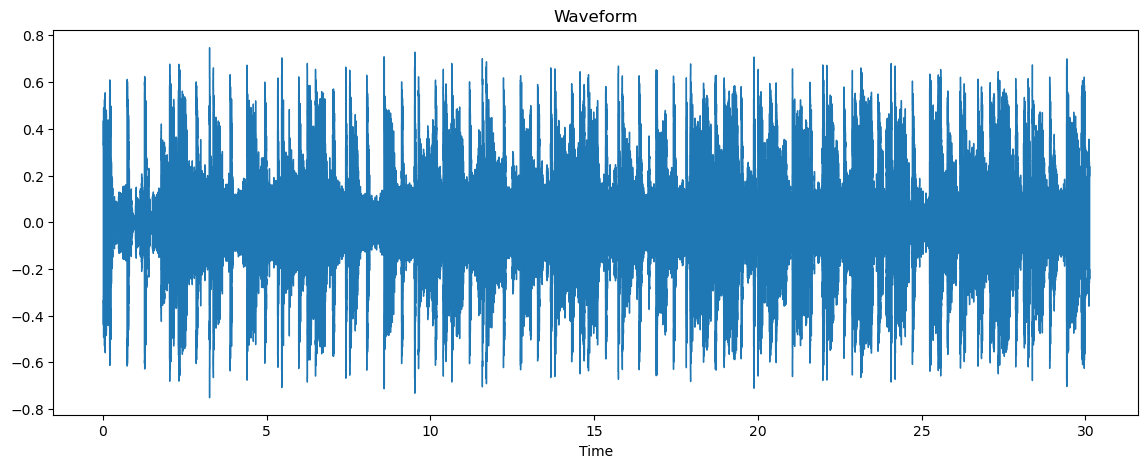

In [6]:
# visualize the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.show()

Observe above how the 30 second audio file is stored as a numpy array of ~665k values. Each value represents the amplitude of the waveform at a given point in time. The rate 'sr' tells us how many samples per second the audio file has.

## Construct Dataset By Iterating Through Each Genre

In [7]:
# create empty dataframe to store the data
data = {'filename':[],
        'genre':[],
        'audio':[],
        'rate':[]}

audio_df = pd.DataFrame(data)

In [8]:
# define function taking a waveform to Mel
def waveform_to_mel(audio_data, sr=22050):
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# create a function for processing each audio file
def process_audio_file(audio_path, genre):
    
    try:
        # change the waveform to Mel
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = waveform_to_mel(y, sr) 
        mel_spec = mel_spec.T  

        # Save mel file
        base_name = os.path.splitext(os.path.basename(audio_path))[0]
        save_name = f"{genre}_{base_name}.npy"
        save_path = os.path.join(MEL_SAVE_DIR, save_name)
        np.save(save_path, mel_spec.astype(np.float32))

        return {
            'filename': base_name,
            'genre': genre,
            'mel_path': save_path
        }

    except Exception as e:
        print(f"Skipping {audio_path}: {e}")
        return None

In [16]:
# generate the audio dataframe by looping through directory containing the files
# define the save directory
MEL_SAVE_DIR = 'mel_specs/'
os.makedirs(MEL_SAVE_DIR, exist_ok=True)

audio_tasks = []
for genre in os.listdir(audio_dir):
    genre_path = os.path.join(audio_dir, genre)
    for file in os.listdir(genre_path):
        if file.lower().endswith('.wav'):
            audio_path = os.path.join(genre_path, file)
            audio_tasks.append((audio_path, genre))

results = Parallel(n_jobs=8)(delayed(process_audio_file)(path, genre) for path, genre in audio_tasks)

# build dataframe
audio_df = pd.DataFrame([r for r in results if r is not None])

print(audio_df.head(5)) 
print('The length of the dataframe is: ' + str(len(audio_df)))

           filename  genre                              mel_path
0       blues.00000  blues       mel_specs/blues_blues.00000.npy
1  blues.00000_aug1  blues  mel_specs/blues_blues.00000_aug1.npy
2  blues.00000_aug2  blues  mel_specs/blues_blues.00000_aug2.npy
3  blues.00000_aug3  blues  mel_specs/blues_blues.00000_aug3.npy
4  blues.00000_aug4  blues  mel_specs/blues_blues.00000_aug4.npy
The length of the dataframe is: 5994


In [17]:
# create class that allows us to load in the data and generate labels
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

        # build label mapping
        genres = sorted(self.data['genre'].unique())
        self.label_map = {genre: idx for idx, genre in enumerate(genres)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        mel = np.load(row['mel_path'])
        label = self.label_map[row['genre']]

        mel = torch.tensor(mel, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            mel = self.transform(mel)

        return mel, label

In [18]:
# make the transformer classifier
class SimpleTransformerClassifier(nn.Module):
    def __init__(self,
                 input_dim=128,
                 seq_len=1290,
                 d_model=256,
                 num_classes=10,
                 num_heads=4,
                 num_layers=4,
                 dim_feedforward=512,
                 dropout=0.1):
        super().__init__()
        
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.cls_norm = nn.LayerNorm(d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # make the positional encoding
        pe = self._generate_sinusoidal_pos_encoding(seq_len + 1, d_model)  # +1 to include CLS token position
        self.register_buffer('pos_embedding', pe)
        
        # make the encoder layer
        encoder_layer = CustomTranformerEncoder(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
        
    # define a function that does sinusoidal encodings
    def _generate_sinusoidal_pos_encoding(self, seq_len, d_model):
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.input_proj(x)
        
        # add CLS token
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_token, x], dim=1)

        # add positional encoding
        pos_embed = self.pos_embedding.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, seq_len, d_model)
        x = x + pos_embed
        x = x.permute(1, 0, 2)
        
        # pass through transformer
        x = self.transformer_encoder(x)
        
       # extract CLS token's output and normalize
        cls_out = x[0]
        cls_out = self.cls_norm(cls_out)

        # get output
        out = self.classifier(cls_out)
        return out
        
# custom transformer layer to get access to attention weights
class CustomTranformerEncoder(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None 
        
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2, attn = self.self_attn(src, src, src, attn_mask=src_mask,
                                    key_padding_mask=src_key_padding_mask,
                                    need_weights=True,
                                    average_attn_weights=False,
                                    is_causal=is_causal)
        self.attn_weights = attn
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [19]:
# create the model 
model = SimpleTransformerClassifier().to(device)

# fake batch of mel spectrograms (batch_size=4) to check the shapes
dummy_input = torch.randn(4, 1290, 128).to(device)
output = model(dummy_input)

# access attention from last encoder layer
last_layer = model.transformer_encoder.layers[-1]
attn_weights = last_layer.attn_weights

print("Attention weights shape: ", attn_weights.shape)
print(output.shape)

Attention weights shape:  torch.Size([4, 4, 1291, 1291])
torch.Size([4, 10])


In [20]:
# put the sequence length
FIXED_SEQ_LEN = 1290 

# function that ensures that all spectrograms in a batch are of the same length
def pad_collate(batch):
    mels, labels = zip(*batch)
    fixed_mels = []
    for mel in mels:
        T = mel.shape[0]
        if T > FIXED_SEQ_LEN:
            mel = mel[:FIXED_SEQ_LEN, :]
        elif T < FIXED_SEQ_LEN:
            pad_len = FIXED_SEQ_LEN - T
            mel = F.pad(mel, (0, 0, 0, pad_len))
        fixed_mels.append(mel)
    return torch.stack(fixed_mels), torch.tensor(labels, dtype=torch.long)


In [21]:
# split the data
train_df, test_df = train_test_split(audio_df, test_size=0.2, stratify=audio_df['genre'], random_state=42)

# make dataset and loaders
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=pad_collate)

In [23]:
# create the label encodings
label_encoder = LabelEncoder()
label_encoder.fit(audio_df['genre'])
n_classes = len(label_encoder.classes_)


# initial conditions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 100
best_acc = 0.0

# iterate over the model, showing the training and testing accuracy after each epoch
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct_train, total_train = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)

        # forward
        preds = model(xb)
        loss = criterion(preds, yb)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        running_loss += loss.item()
        correct_train += (preds.argmax(1) == yb).sum().item()
        total_train += yb.size(0)

        loop.set_postfix(loss=loss.item(), acc=100 * correct_train / total_train)

    train_acc = correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    # eval on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            correct_test += (preds == y_batch).sum().item()
            total_test += y_batch.size(0)
    
    test_acc = correct_test / total_test

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, Test Acc: {100 * test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Saved new best model with accuracy: {best_acc:.4f}")

Epoch 1/100: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s, acc=24.7, loss=1.6] 


[Epoch 1] Train Loss: 2.0365, Train Acc: 24.65%, Test Acc: 41.70%
Saved new best model with accuracy: 0.4170


Epoch 2/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=51, loss=1.52]   


[Epoch 2] Train Loss: 1.3576, Train Acc: 51.03%, Test Acc: 59.38%
Saved new best model with accuracy: 0.5938


Epoch 3/100: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s, acc=63.6, loss=1.68] 


[Epoch 3] Train Loss: 1.0212, Train Acc: 63.63%, Test Acc: 62.05%
Saved new best model with accuracy: 0.6205


Epoch 4/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=73.2, loss=1.2]  


[Epoch 4] Train Loss: 0.7774, Train Acc: 73.16%, Test Acc: 78.40%
Saved new best model with accuracy: 0.7840


Epoch 5/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=80.3, loss=0.222]


[Epoch 5] Train Loss: 0.5884, Train Acc: 80.25%, Test Acc: 80.82%
Saved new best model with accuracy: 0.8082


Epoch 6/100: 100%|██████████| 300/300 [00:42<00:00,  7.09it/s, acc=86.5, loss=0.228]


[Epoch 6] Train Loss: 0.4260, Train Acc: 86.53%, Test Acc: 82.40%
Saved new best model with accuracy: 0.8240


Epoch 7/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=88.5, loss=0.24]  


[Epoch 7] Train Loss: 0.3490, Train Acc: 88.47%, Test Acc: 81.65%


Epoch 8/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=92.4, loss=0.461] 


[Epoch 8] Train Loss: 0.2464, Train Acc: 92.39%, Test Acc: 87.16%
Saved new best model with accuracy: 0.8716


Epoch 9/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=94.1, loss=0.201] 


[Epoch 9] Train Loss: 0.1934, Train Acc: 94.14%, Test Acc: 86.82%


Epoch 10/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=94.4, loss=0.074]  


[Epoch 10] Train Loss: 0.1776, Train Acc: 94.41%, Test Acc: 88.32%
Saved new best model with accuracy: 0.8832


Epoch 11/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=96.2, loss=0.07]   


[Epoch 11] Train Loss: 0.1185, Train Acc: 96.20%, Test Acc: 87.41%


Epoch 12/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=95.2, loss=0.139] 


[Epoch 12] Train Loss: 0.1397, Train Acc: 95.20%, Test Acc: 89.24%
Saved new best model with accuracy: 0.8924


Epoch 13/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=95.7, loss=0.0453] 


[Epoch 13] Train Loss: 0.1318, Train Acc: 95.70%, Test Acc: 89.99%
Saved new best model with accuracy: 0.8999


Epoch 14/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=97.3, loss=0.13]   


[Epoch 14] Train Loss: 0.0866, Train Acc: 97.29%, Test Acc: 86.07%


Epoch 15/100: 100%|██████████| 300/300 [00:43<00:00,  6.92it/s, acc=96.4, loss=0.186]  


[Epoch 15] Train Loss: 0.1138, Train Acc: 96.37%, Test Acc: 91.41%
Saved new best model with accuracy: 0.9141


Epoch 16/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=97.7, loss=0.0108] 


[Epoch 16] Train Loss: 0.0674, Train Acc: 97.73%, Test Acc: 90.49%


Epoch 17/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.4, loss=0.0828] 


[Epoch 17] Train Loss: 0.0579, Train Acc: 98.39%, Test Acc: 91.24%


Epoch 18/100: 100%|██████████| 300/300 [00:42<00:00,  7.14it/s, acc=97.8, loss=0.0446] 


[Epoch 18] Train Loss: 0.0661, Train Acc: 97.81%, Test Acc: 92.74%
Saved new best model with accuracy: 0.9274


Epoch 19/100: 100%|██████████| 300/300 [00:42<00:00,  7.07it/s, acc=97.3, loss=0.102]  


[Epoch 19] Train Loss: 0.0725, Train Acc: 97.29%, Test Acc: 88.82%


Epoch 20/100: 100%|██████████| 300/300 [00:42<00:00,  7.10it/s, acc=98, loss=0.0204]   


[Epoch 20] Train Loss: 0.0600, Train Acc: 97.98%, Test Acc: 91.08%


Epoch 21/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.5, loss=0.113]  


[Epoch 21] Train Loss: 0.0502, Train Acc: 98.46%, Test Acc: 91.58%


Epoch 22/100: 100%|██████████| 300/300 [00:42<00:00,  7.03it/s, acc=97.8, loss=0.019]  


[Epoch 22] Train Loss: 0.0756, Train Acc: 97.79%, Test Acc: 91.16%


Epoch 23/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=97.6, loss=0.00153]


[Epoch 23] Train Loss: 0.0709, Train Acc: 97.60%, Test Acc: 91.66%


Epoch 24/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=98.3, loss=0.00281] 


[Epoch 24] Train Loss: 0.0473, Train Acc: 98.33%, Test Acc: 90.41%


Epoch 25/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=98, loss=0.0181]   


[Epoch 25] Train Loss: 0.0600, Train Acc: 98.04%, Test Acc: 93.16%
Saved new best model with accuracy: 0.9316


Epoch 26/100: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s, acc=99, loss=0.00268]   


[Epoch 26] Train Loss: 0.0299, Train Acc: 99.00%, Test Acc: 92.99%


Epoch 27/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=97.6, loss=0.0274]  


[Epoch 27] Train Loss: 0.0717, Train Acc: 97.64%, Test Acc: 90.74%


Epoch 28/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.7, loss=0.00448] 


[Epoch 28] Train Loss: 0.0121, Train Acc: 99.69%, Test Acc: 93.83%
Saved new best model with accuracy: 0.9383


Epoch 29/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=99.5, loss=0.00181] 


[Epoch 29] Train Loss: 0.0185, Train Acc: 99.52%, Test Acc: 93.74%


Epoch 30/100: 100%|██████████| 300/300 [00:42<00:00,  7.10it/s, acc=95.4, loss=0.00773]


[Epoch 30] Train Loss: 0.1429, Train Acc: 95.37%, Test Acc: 90.83%


Epoch 31/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=98.5, loss=0.064]   


[Epoch 31] Train Loss: 0.0450, Train Acc: 98.46%, Test Acc: 89.82%


Epoch 32/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=98.9, loss=0.0475] 


[Epoch 32] Train Loss: 0.0357, Train Acc: 98.92%, Test Acc: 92.33%


Epoch 33/100: 100%|██████████| 300/300 [00:42<00:00,  7.09it/s, acc=98, loss=0.00281]  


[Epoch 33] Train Loss: 0.0602, Train Acc: 98.02%, Test Acc: 90.91%


Epoch 34/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=98, loss=0.507]     


[Epoch 34] Train Loss: 0.0578, Train Acc: 98.02%, Test Acc: 90.99%


Epoch 35/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=99.7, loss=0.00259] 


[Epoch 35] Train Loss: 0.0144, Train Acc: 99.73%, Test Acc: 91.91%


Epoch 36/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=98.1, loss=0.00326] 


[Epoch 36] Train Loss: 0.0601, Train Acc: 98.08%, Test Acc: 90.91%


Epoch 37/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=98.1, loss=0.00234] 


[Epoch 37] Train Loss: 0.0552, Train Acc: 98.06%, Test Acc: 92.74%


Epoch 38/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=98.7, loss=0.000477]


[Epoch 38] Train Loss: 0.0389, Train Acc: 98.73%, Test Acc: 92.16%


Epoch 39/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=99.4, loss=0.00709] 


[Epoch 39] Train Loss: 0.0238, Train Acc: 99.44%, Test Acc: 92.24%


Epoch 40/100: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s, acc=98.3, loss=0.288]   


[Epoch 40] Train Loss: 0.0519, Train Acc: 98.29%, Test Acc: 90.66%


Epoch 41/100: 100%|██████████| 300/300 [00:41<00:00,  7.14it/s, acc=97.2, loss=0.00367] 


[Epoch 41] Train Loss: 0.0771, Train Acc: 97.21%, Test Acc: 90.66%


Epoch 42/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=99.2, loss=0.00164] 


[Epoch 42] Train Loss: 0.0289, Train Acc: 99.19%, Test Acc: 92.99%


Epoch 43/100: 100%|██████████| 300/300 [00:43<00:00,  6.82it/s, acc=99.6, loss=0.00267] 


[Epoch 43] Train Loss: 0.0162, Train Acc: 99.56%, Test Acc: 94.16%
Saved new best model with accuracy: 0.9416


Epoch 44/100: 100%|██████████| 300/300 [00:42<00:00,  7.11it/s, acc=99.9, loss=0.0082]  


[Epoch 44] Train Loss: 0.0074, Train Acc: 99.85%, Test Acc: 93.58%


Epoch 45/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=96.8, loss=0.0133]  


[Epoch 45] Train Loss: 0.0880, Train Acc: 96.79%, Test Acc: 91.41%


Epoch 46/100: 100%|██████████| 300/300 [00:42<00:00,  7.10it/s, acc=98.5, loss=0.00187] 


[Epoch 46] Train Loss: 0.0385, Train Acc: 98.52%, Test Acc: 90.08%


Epoch 47/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.4, loss=0.0217]  


[Epoch 47] Train Loss: 0.0207, Train Acc: 99.42%, Test Acc: 88.32%


Epoch 48/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=97.9, loss=0.00139] 


[Epoch 48] Train Loss: 0.0609, Train Acc: 97.94%, Test Acc: 91.49%


Epoch 49/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=98.7, loss=0.0365]  


[Epoch 49] Train Loss: 0.0359, Train Acc: 98.71%, Test Acc: 91.41%


Epoch 50/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=98.3, loss=0.00132] 


[Epoch 50] Train Loss: 0.0475, Train Acc: 98.29%, Test Acc: 91.99%


Epoch 51/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.3, loss=0.000426]


[Epoch 51] Train Loss: 0.0185, Train Acc: 99.33%, Test Acc: 92.24%


Epoch 52/100: 100%|██████████| 300/300 [00:42<00:00,  7.14it/s, acc=99.6, loss=0.0046]  


[Epoch 52] Train Loss: 0.0141, Train Acc: 99.56%, Test Acc: 90.49%


Epoch 53/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.3, loss=0.00548] 


[Epoch 53] Train Loss: 0.0220, Train Acc: 99.33%, Test Acc: 91.99%


Epoch 54/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=98.3, loss=0.144]   


[Epoch 54] Train Loss: 0.0524, Train Acc: 98.29%, Test Acc: 89.99%


Epoch 55/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=98.6, loss=0.00393] 


[Epoch 55] Train Loss: 0.0396, Train Acc: 98.62%, Test Acc: 88.16%


Epoch 56/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.1, loss=0.0435]  


[Epoch 56] Train Loss: 0.0299, Train Acc: 99.12%, Test Acc: 91.33%


Epoch 57/100: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s, acc=99.4, loss=0.000786]


[Epoch 57] Train Loss: 0.0197, Train Acc: 99.40%, Test Acc: 93.16%


Epoch 58/100: 100%|██████████| 300/300 [00:42<00:00,  7.03it/s, acc=99.9, loss=0.000134]


[Epoch 58] Train Loss: 0.0036, Train Acc: 99.94%, Test Acc: 93.91%


Epoch 59/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99, loss=0.00658]   


[Epoch 59] Train Loss: 0.0299, Train Acc: 99.04%, Test Acc: 91.33%


Epoch 60/100: 100%|██████████| 300/300 [00:42<00:00,  6.98it/s, acc=97, loss=0.026]     


[Epoch 60] Train Loss: 0.0899, Train Acc: 97.04%, Test Acc: 91.99%


Epoch 61/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.4, loss=0.000142]


[Epoch 61] Train Loss: 0.0420, Train Acc: 98.37%, Test Acc: 92.49%


Epoch 62/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=99.1, loss=0.303]   


[Epoch 62] Train Loss: 0.0306, Train Acc: 99.12%, Test Acc: 91.41%


Epoch 63/100: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s, acc=98.8, loss=0.0816]  


[Epoch 63] Train Loss: 0.0316, Train Acc: 98.81%, Test Acc: 91.49%


Epoch 64/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.1, loss=0.00054] 


[Epoch 64] Train Loss: 0.0258, Train Acc: 99.10%, Test Acc: 92.66%


Epoch 65/100: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s, acc=99.4, loss=0.00133] 


[Epoch 65] Train Loss: 0.0186, Train Acc: 99.35%, Test Acc: 92.99%


Epoch 66/100: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s, acc=99.1, loss=9.6e-5]  


[Epoch 66] Train Loss: 0.0273, Train Acc: 99.10%, Test Acc: 92.74%


Epoch 67/100: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s, acc=99.4, loss=0.00253] 


[Epoch 67] Train Loss: 0.0186, Train Acc: 99.42%, Test Acc: 93.33%


Epoch 68/100: 100%|██████████| 300/300 [00:42<00:00,  6.99it/s, acc=99.2, loss=0.00028] 


[Epoch 68] Train Loss: 0.0281, Train Acc: 99.19%, Test Acc: 91.66%


Epoch 69/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=99.9, loss=0.00251] 


[Epoch 69] Train Loss: 0.0058, Train Acc: 99.87%, Test Acc: 93.74%


Epoch 70/100: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s, acc=98.4, loss=0.0428]  


[Epoch 70] Train Loss: 0.0466, Train Acc: 98.44%, Test Acc: 91.16%


Epoch 71/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.2, loss=0.0267]  


[Epoch 71] Train Loss: 0.0515, Train Acc: 98.25%, Test Acc: 90.49%


Epoch 72/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=99.1, loss=0.000401]


[Epoch 72] Train Loss: 0.0285, Train Acc: 99.08%, Test Acc: 93.49%


Epoch 73/100: 100%|██████████| 300/300 [00:42<00:00,  7.05it/s, acc=99.2, loss=0.00182] 


[Epoch 73] Train Loss: 0.0228, Train Acc: 99.19%, Test Acc: 92.08%


Epoch 74/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.8, loss=0.005]   


[Epoch 74] Train Loss: 0.0077, Train Acc: 99.81%, Test Acc: 92.49%


Epoch 75/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=99.4, loss=0.00506] 


[Epoch 75] Train Loss: 0.0245, Train Acc: 99.35%, Test Acc: 93.08%


Epoch 76/100: 100%|██████████| 300/300 [00:42<00:00,  7.10it/s, acc=97.9, loss=0.00125] 


[Epoch 76] Train Loss: 0.0634, Train Acc: 97.85%, Test Acc: 94.08%


Epoch 77/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=99, loss=0.309]     


[Epoch 77] Train Loss: 0.0309, Train Acc: 99.00%, Test Acc: 90.41%


Epoch 78/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=98.2, loss=0.0087]  


[Epoch 78] Train Loss: 0.0535, Train Acc: 98.23%, Test Acc: 88.16%


Epoch 79/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=99.4, loss=0.0306]  


[Epoch 79] Train Loss: 0.0211, Train Acc: 99.35%, Test Acc: 88.07%


Epoch 80/100: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s, acc=99.8, loss=0.000751]


[Epoch 80] Train Loss: 0.0089, Train Acc: 99.79%, Test Acc: 93.66%


Epoch 81/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.9, loss=0.000773]


[Epoch 81] Train Loss: 0.0046, Train Acc: 99.90%, Test Acc: 94.41%
Saved new best model with accuracy: 0.9441


Epoch 82/100: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s, acc=99.9, loss=0.000249]


[Epoch 82] Train Loss: 0.0035, Train Acc: 99.90%, Test Acc: 94.25%


Epoch 83/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.9, loss=0.0444]  


[Epoch 83] Train Loss: 0.0057, Train Acc: 99.85%, Test Acc: 91.08%


Epoch 84/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=96.5, loss=0.0146]  


[Epoch 84] Train Loss: 0.1093, Train Acc: 96.50%, Test Acc: 89.07%


Epoch 85/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.5, loss=0.000737]


[Epoch 85] Train Loss: 0.0171, Train Acc: 99.46%, Test Acc: 93.08%


Epoch 86/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=99.7, loss=0.000607]


[Epoch 86] Train Loss: 0.0124, Train Acc: 99.73%, Test Acc: 93.58%


Epoch 87/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=99.1, loss=0.0272]  


[Epoch 87] Train Loss: 0.0301, Train Acc: 99.08%, Test Acc: 89.74%


Epoch 88/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.9, loss=0.0023]  


[Epoch 88] Train Loss: 0.0351, Train Acc: 98.87%, Test Acc: 91.49%


Epoch 89/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=99.4, loss=0.0593]  


[Epoch 89] Train Loss: 0.0201, Train Acc: 99.40%, Test Acc: 90.99%


Epoch 90/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=98.9, loss=0.0272]  


[Epoch 90] Train Loss: 0.0341, Train Acc: 98.92%, Test Acc: 91.33%


Epoch 91/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=98.7, loss=0.000762]


[Epoch 91] Train Loss: 0.0360, Train Acc: 98.75%, Test Acc: 93.08%


Epoch 92/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=99.7, loss=0.00149] 


[Epoch 92] Train Loss: 0.0099, Train Acc: 99.69%, Test Acc: 93.33%


Epoch 93/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=99.9, loss=0.000339]


[Epoch 93] Train Loss: 0.0046, Train Acc: 99.87%, Test Acc: 93.08%


Epoch 94/100: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s, acc=97.9, loss=0.0303]  


[Epoch 94] Train Loss: 0.0651, Train Acc: 97.89%, Test Acc: 89.24%


Epoch 95/100: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s, acc=99, loss=0.000769]  


[Epoch 95] Train Loss: 0.0289, Train Acc: 99.00%, Test Acc: 92.08%


Epoch 96/100: 100%|██████████| 300/300 [00:42<00:00,  7.13it/s, acc=99.8, loss=0.000504]


[Epoch 96] Train Loss: 0.0078, Train Acc: 99.83%, Test Acc: 92.58%


Epoch 97/100: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s, acc=99.5, loss=0.00178] 


[Epoch 97] Train Loss: 0.0106, Train Acc: 99.54%, Test Acc: 92.16%


Epoch 98/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=99.5, loss=0.00482] 


[Epoch 98] Train Loss: 0.0162, Train Acc: 99.54%, Test Acc: 92.58%


Epoch 99/100: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s, acc=98.9, loss=0.000597]


[Epoch 99] Train Loss: 0.0302, Train Acc: 98.87%, Test Acc: 91.66%


Epoch 100/100: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s, acc=99.3, loss=0.000451]


[Epoch 100] Train Loss: 0.0213, Train Acc: 99.33%, Test Acc: 92.58%


In [24]:
# inverse the genre encodings
y = audio_df['genre']
y_encoded = label_encoder.fit_transform(y)
original_labels = label_encoder.inverse_transform(y_encoded)

In [53]:
# load the saved state_dict from file
saved_state = torch.load('best_model.pt')

# create the current model architecture (must match what was used during training)
model = SimpleTransformerClassifier(
    input_dim=128,
    seq_len=1290,
    d_model=256,
    num_classes=10,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1
)

# get the current model's state dict
current_state = model.state_dict(saved_state)
model = model.to(device)

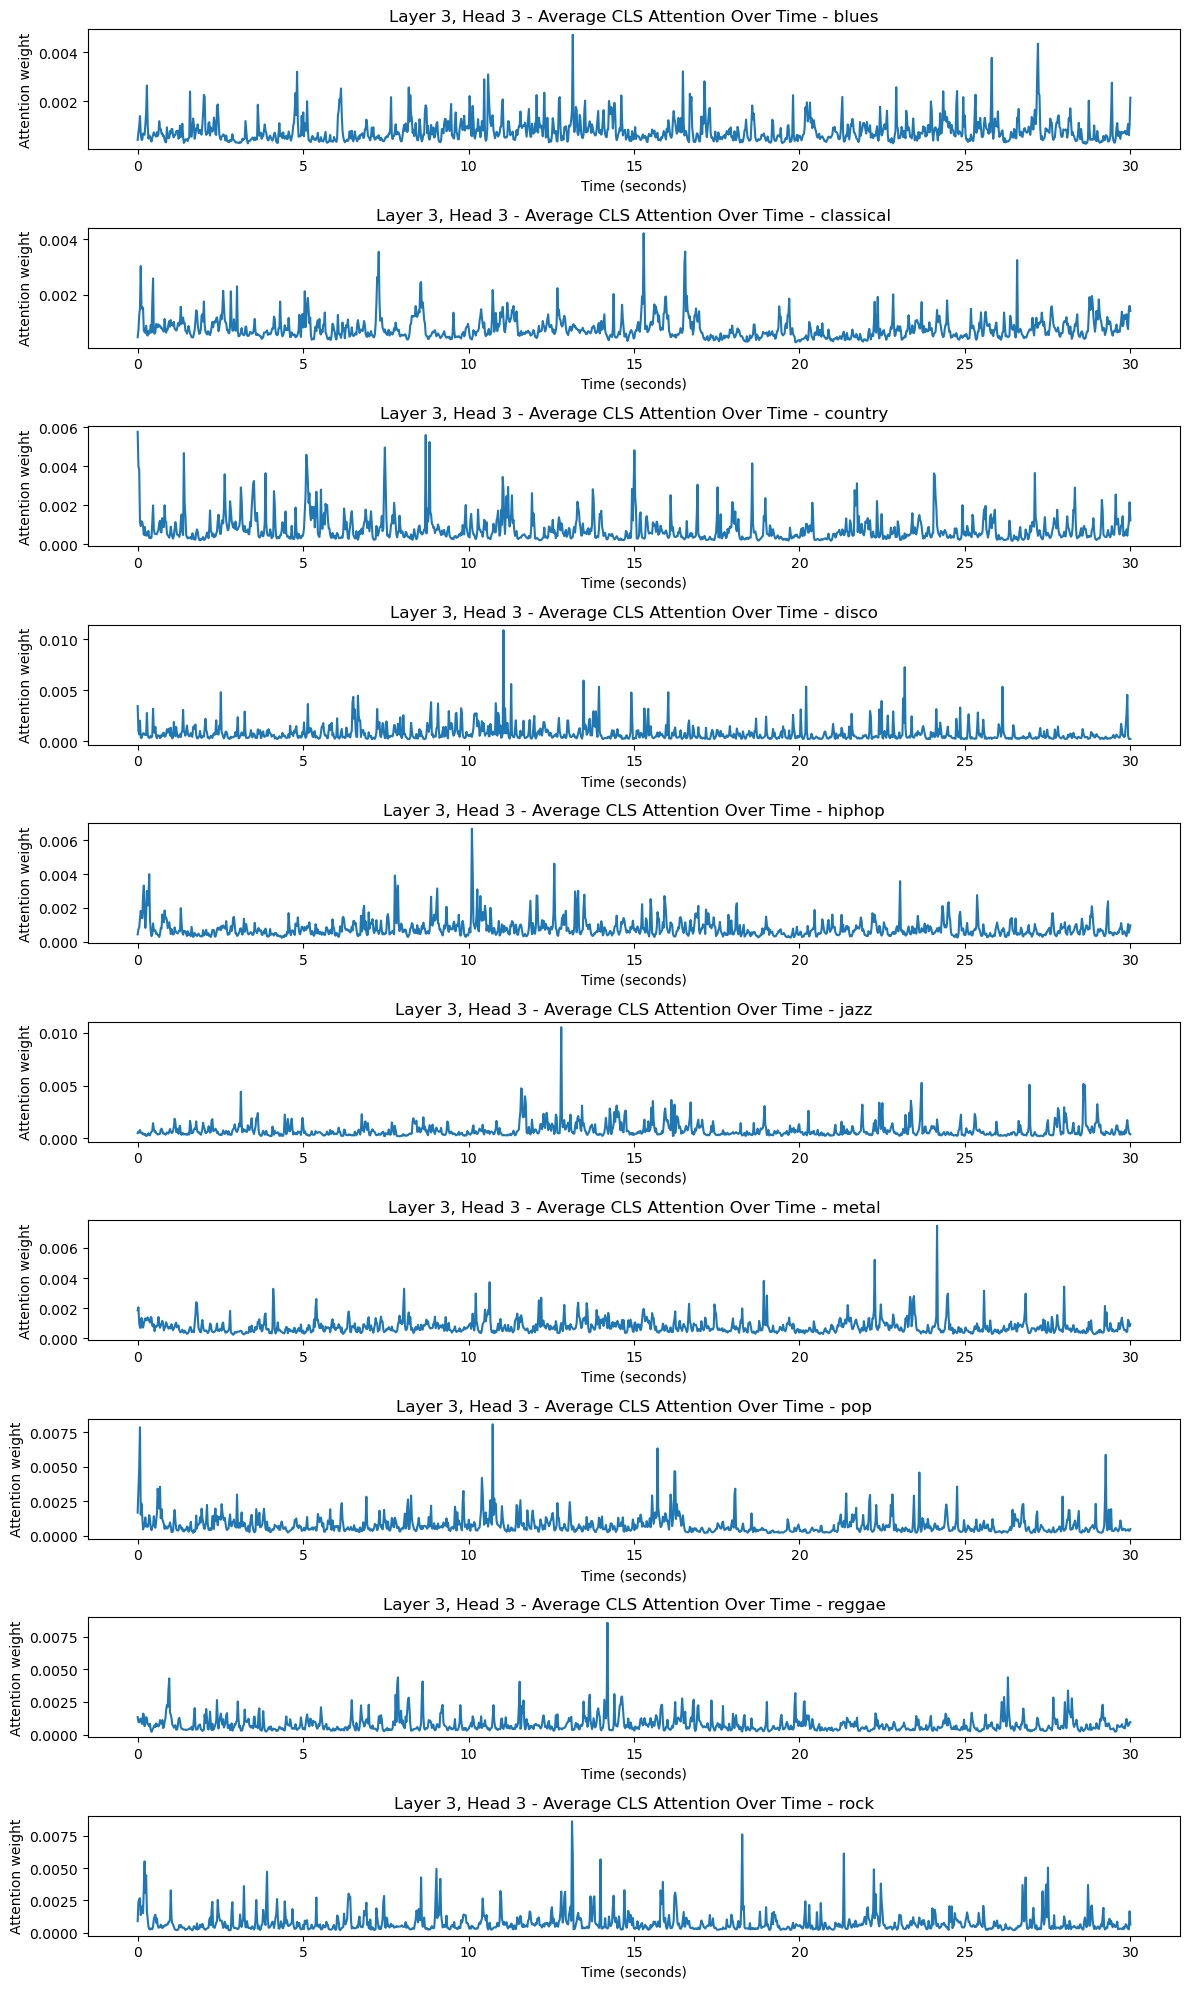

In [70]:
# dictionary: genre_idx -> list of attention vectors (for layer 3, head 3)

# collect attention vectors
model.to(device)
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        _ = model(X_batch)  

        # extract attention weights from layer 3 
        layer = model.transformer_encoder.layers[2]
        attn = layer.attn_weights 

        for i in range(X_batch.size(0)):
            genre = y_batch[i].item()
            cls_attn_head3 = attn[i, 2, 0, 1:].detach().cpu()  # Shape: (seq_len,)
            genre_attention_head3[genre].append(cls_attn_head3.numpy())

# compute average attention vector per genre
genre_avg_attention_head3 = defaultdict(list)
for genre_idx, attn_list in genre_attention_head3.items():
    attn_array = np.stack(attn_list) 
    genre_avg = attn_array.mean(axis=0)  
    genre_avg_attention_head3[genre_idx] = genre_avg

# plot average attention over time for each genre
genre_names = label_encoder.classes_
seq_len = next(iter(genre_avg_attention_head3.values())).shape[0]
time_axis = np.linspace(0, 30, seq_len)

num_genres = len(genre_avg_attention_head3)
plt.figure(figsize=(12, num_genres * 2))

for genre_idx, attn_vec in genre_avg_attention_head3.items():
    genre_name = genre_names[genre_idx]
    plt.subplot(num_genres, 1, genre_idx + 1)
    plt.plot(time_axis, attn_vec)
    plt.title(f'Layer 3, Head 3 - Average CLS Attention Over Time - {genre_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Attention weight')

plt.tight_layout()
plt.show()

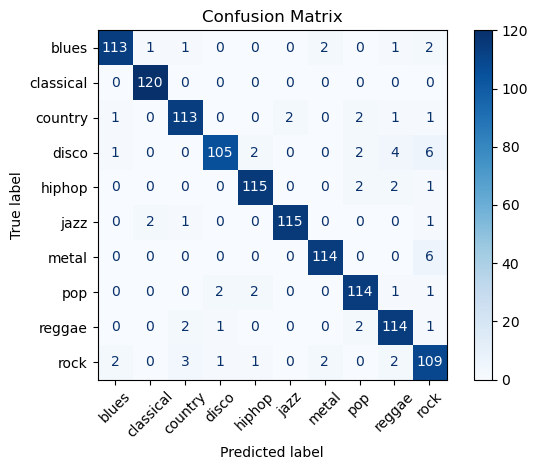

In [71]:
# reload the model to make the confusion matrix
model = SimpleTransformerClassifier(
    input_dim=128,
    seq_len=1290,
    d_model=256,
    num_classes=10,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1
) 

model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# use label map
label_map = test_dataset.label_map
inv_label_map = {v: k for k, v in label_map.items()}
class_names = [inv_label_map[i] for i in sorted(inv_label_map)]

# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png") 
plt.show()

In [72]:
# make the classification report
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       blues       0.97      0.94      0.95       120
   classical       0.98      1.00      0.99       120
     country       0.94      0.94      0.94       120
       disco       0.96      0.88      0.92       120
      hiphop       0.96      0.96      0.96       120
        jazz       0.98      0.97      0.97       119
       metal       0.97      0.95      0.96       120
         pop       0.93      0.95      0.94       120
      reggae       0.91      0.95      0.93       120
        rock       0.85      0.91      0.88       120

    accuracy                           0.94      1199
   macro avg       0.95      0.94      0.94      1199
weighted avg       0.95      0.94      0.94      1199



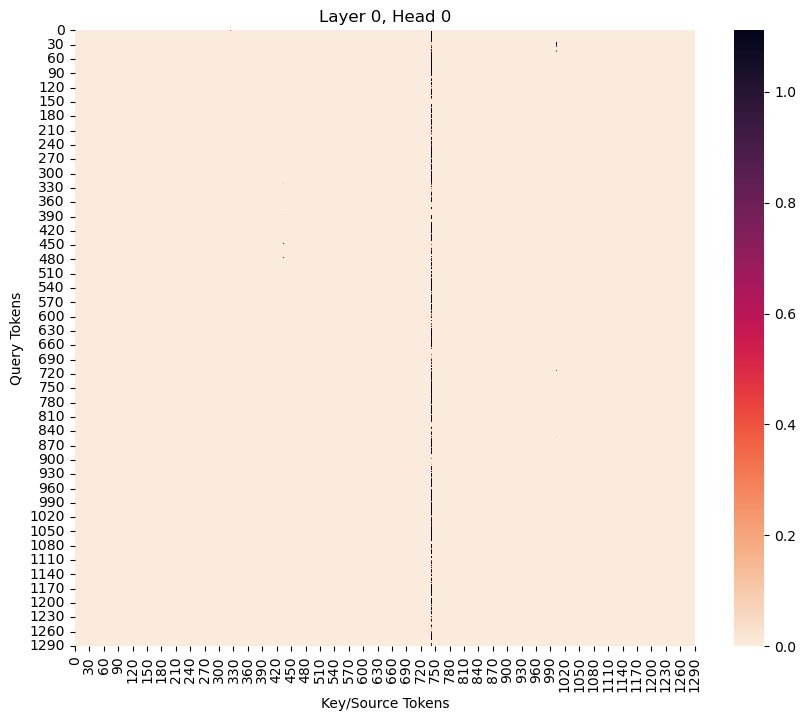

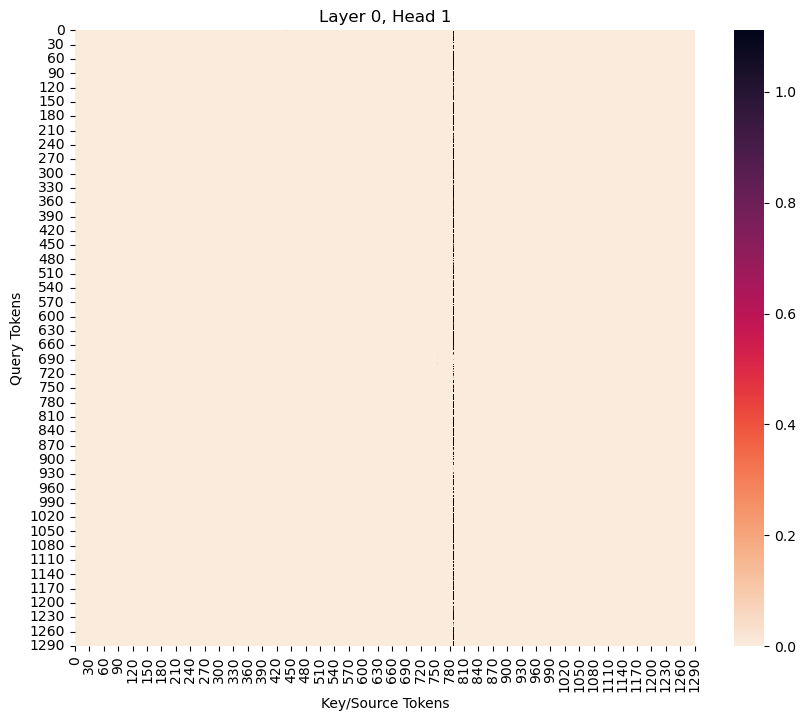

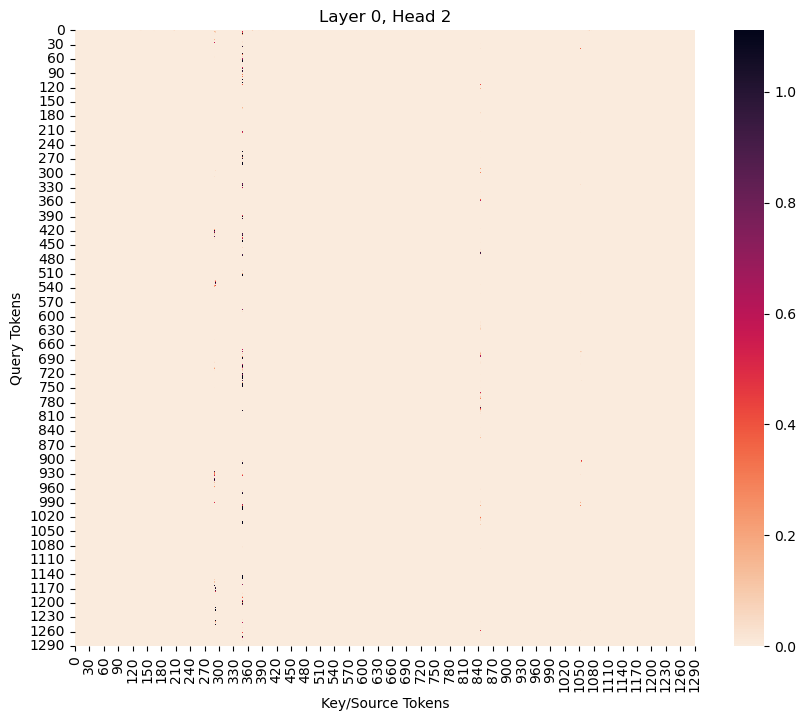

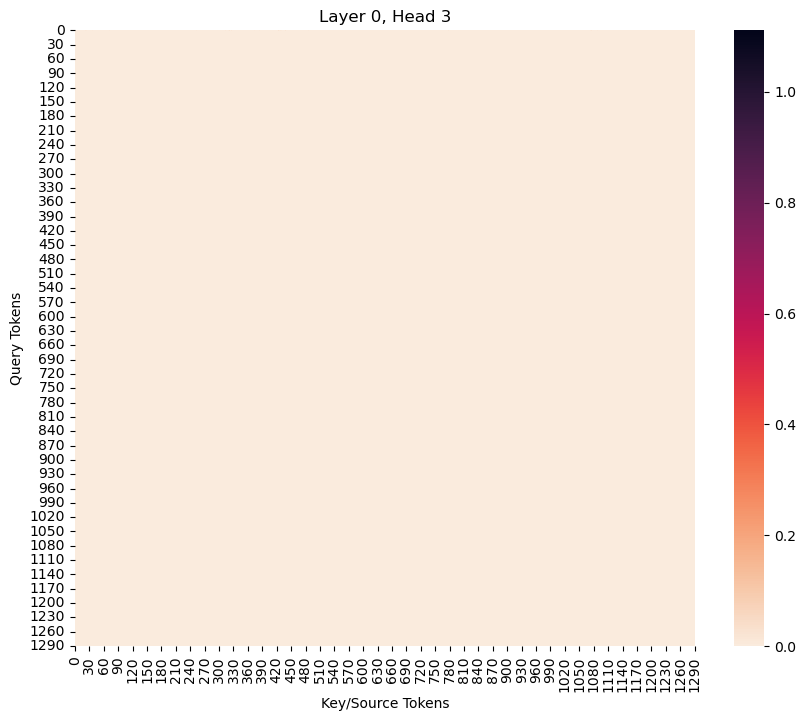

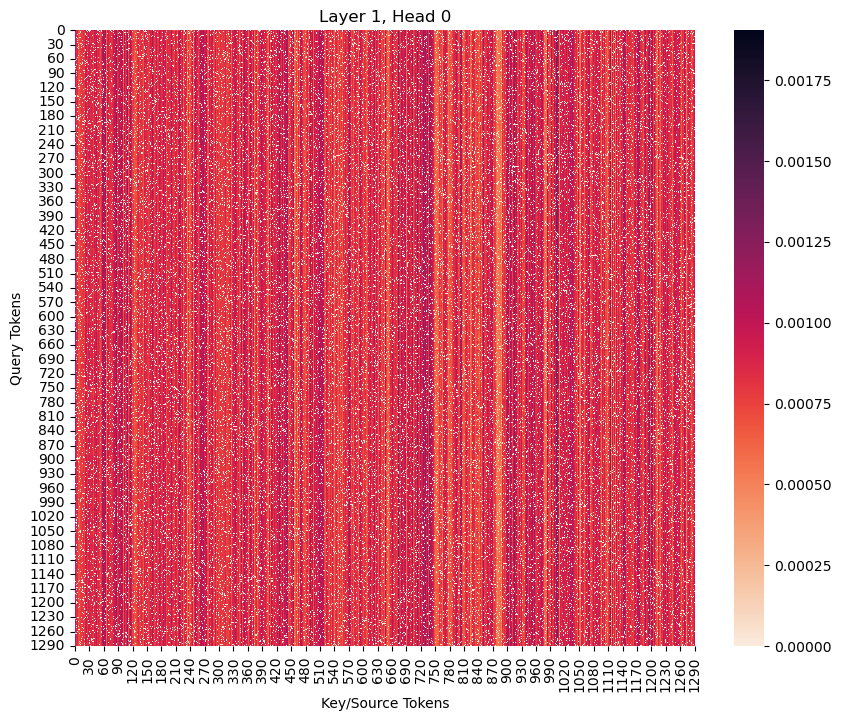

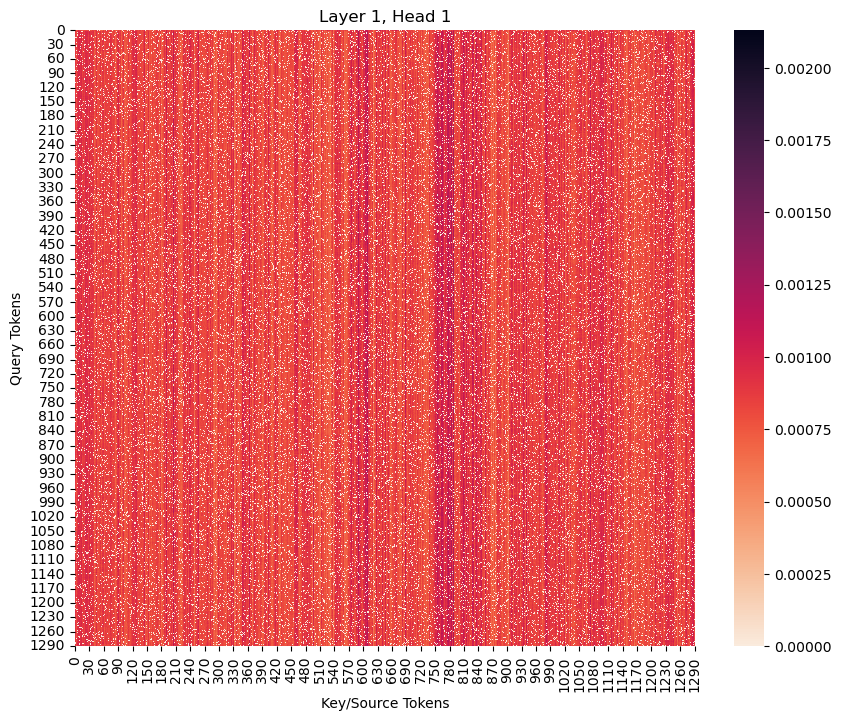

In [ ]:
# reload the model to get state_dict
saved_state = torch.load('best_model.pt')
model = SimpleTransformerClassifier(
    input_dim=128,
    seq_len=1290,
    d_model=256,
    num_classes=10,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1
)
current_state = model.state_dict(saved_state)
model = model.to(device)

# forward pass on one example
X_example = X_batch[0].unsqueeze(0).to(device)

with torch.no_grad():
    _ = model(X_example)

# loop through each transformer layer and head
for layer_idx, layer in enumerate(model.transformer_encoder.layers):
    attn = layer.attn_weights  # Shape: (batch_size, num_heads, seq_len+1, seq_len+1)

    if attn is None:
        continue

    batch_idx = 0
    for head_idx in range(attn.shape[1]):
        attn_map = attn[batch_idx, head_idx].detach().cpu().numpy()

        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_map, cmap='rocket_r')
        plt.title(f'Layer {layer_idx}, Head {head_idx}')
        plt.xlabel('Key/Source Tokens')
        plt.ylabel('Query Tokens')

        # save only Layer 3, Head 3
        if layer_idx == 3 and head_idx == 3:
            plt.savefig("heatmap_layer3_head3.png")

        plt.show()
